In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
import cv2
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc 
from functools import reduce
import wfdb#https://github.com/MIT-LCP/wfdb-python
from wfdb import processing
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(2)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


2


In [2]:
#read train image with CV
train_dir = '/data/tmpexec/ecg/train' #the path of images
trI, trY = [],[]
for iname in os.listdir(train_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(train_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(500,300,3)->(256,256,3)
            trI.append(img)
            trY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(trY),20000))
        sys.stdout.flush()
print('The length of train set is %d'%len(trY))
#read test image with CV
test_dir = '/data/tmpexec/ecg/test' #the path of images
teI, teY = [],[]
for iname in os.listdir(test_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(test_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(500,300,3)->(256,256,3)
            teI.append(img)
            teY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(teY),20000))
        sys.stdout.flush()
print('The length of test set is %d'%len(teY))

20000 / 20000 The length of train set is 20000
20000 / 20000 The length of test set is 20000


In [4]:
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ASHNet(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        #Resnet
        self.net = nn.Sequential(
            ResBlock(in_channels=3, out_channels=16),
            ResBlock(in_channels=16, out_channels=16),
            ResBlock(in_channels=16, out_channels=16, stride=2),
        ) 
        #Attention 
        #self.sa = SpatialAttention() 
        #fully connected
        self.dense = nn.Sequential(
            #nn.Linear(16*128*128, 1024),
            #nn.ReLU(inplace=True),
            #nn.Dropout(p=0.5),
            nn.Linear(16*128*128, code_size)
        )
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net(x)
        #x = self.sa(x)*x
        x = x.view(x.size(0),-1)
        x = self.dense(x)
        return x

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#define model
model = ASHNet(code_size=5).cuda()
criterion  = nn.CrossEntropyLoss().cuda() #ce mutli-classes
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    num_batches = len(trY) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        X_batch = torch.from_numpy(np.array(trI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(np.array(trY[min_idx:max_idx])).type(torch.LongTensor).cuda()
        #forword
        out_batch = model(X_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        #binary-like loss
        loss = criterion(out_batch,y_batch) #F.log_softmax+F.nll_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
#release gpu memory
model = model.cpu()
criterion = criterion.cpu()
torch.cuda.empty_cache()
#torch.cuda.synchronize()
teY_pred = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    X_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    out_batch = best_net(X_batch.permute(0, 3, 1, 2))#forword
    teF.extend(out_batch.cpu().data.numpy().tolist()) #record feature
    out_batch = F.log_softmax(out_batch,dim=1) 
    pred = out_batch.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#confusion matrix
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels ) #labels=['N','S','V','F','Q']
print (cm)
print ('Specificity: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))
print ('Sensitivity of Q: %.6f'%float(cm[4][4]/np.sum(cm[4])))

 2000 / 2000 : loss = 0.020196Eopch:     1 mean_loss = 0.250902
 2000 / 2000 : loss = 0.000715Eopch:     2 mean_loss = 0.052941
 2000 / 2000 : loss = 0.345586Eopch:     3 mean_loss = 0.032916
 2000 / 2000 : loss = 0.000703Eopch:     4 mean_loss = 0.020472
 2000 / 2000 : loss = 0.004175Eopch:     5 mean_loss = 0.010958
 2000 / 2000 : loss = 0.000272Eopch:     6 mean_loss = 0.009610
 2000 / 2000 : loss = 2.7e-053Eopch:     7 mean_loss = 0.007928
 2000 / 2000 : loss = 1e-06054Eopch:     8 mean_loss = 0.006730
 2000 / 2000 : loss = 1.6e-059Eopch:     9 mean_loss = 0.004628
 2000 / 2000 : loss = 5e-06783Eopch:    10 mean_loss = 0.002738
best_loss = 0.002738
 1999 / 2000 Accuracy: 0.742900
[[11490   336  2841   179     0]
 [  528   167   245     4     0]
 [  489    80  3196    23     0]
 [  314     1    94     5     0]
 [    6     0     2     0     0]]
Specificity: 0.773946
Sensitivity of S: 0.176907
Sensitivity of V: 0.843717
Sensitivity of F: 0.012077
Sensitivity of Q: 0.000000


Org data dimension is 5.Embedded data dimension is 2


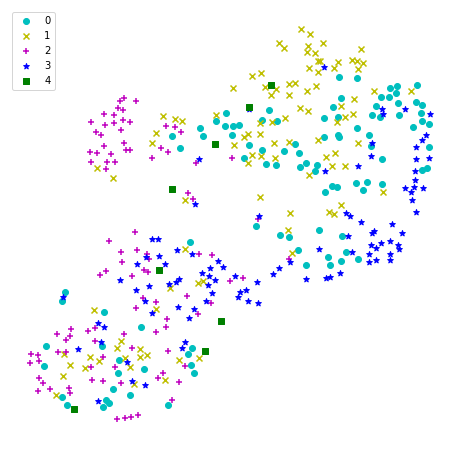

In [5]:
#visualize : t-SNE
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random
def scatter(X, y):
    #X,y:numpy-array
    classes = len(list(set(y.tolist())))#get number of classes
    #palette = np.array(sns.color_palette("hls", classes))# choose a color palette with seaborn.
    color = ['c','y','m','b','g','r']
    marker = ['o','x','+','*','s']
    plt.figure(figsize=(8,8))#create a plot
    for i in range(classes):
        plt.scatter(X[y == i,0], X[y == i,1], c=color[i], marker=marker[i], label=str(i))
    plt.axis('off')
    plt.legend(loc='upper left')
    #plt.savefig('digits_tsne-generated.png', dpi=100)
    plt.show()

#prepare data，classes=5
idx= np.where(np.array(teY)==0)[0].tolist()[0:100]
X0= np.array(teF)[idx]
y0= np.array(teY)[idx]

idx= np.where(np.array(teY)==1)[0].tolist()[0:100]
X1= np.array(teF)[idx]
y1= np.array(teY)[idx]

idx= np.where(np.array(teY)==2)[0].tolist()[0:100]
X2= np.array(teF)[idx]
y2= np.array(teY)[idx]

idx= np.where(np.array(teY)==3)[0].tolist()[0:100]
X3= np.array(teF)[idx]
y3= np.array(teY)[idx]

idx= np.where(np.array(teY)==4)[0].tolist()
X4= np.array(teF)[idx]
y4= np.array(teY)[idx]

y = np.append(y0,y1)
y = np.append(y,y2)
y = np.append(y,y3)
y = np.append(y,y4)
X = np.vstack((X0,X1))
X = np.vstack((X,X2))
X = np.vstack((X,X3))
X = np.vstack((X,X4))
#training t-sne 
tsne = TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

#visualize
scatter(X_tsne, y)

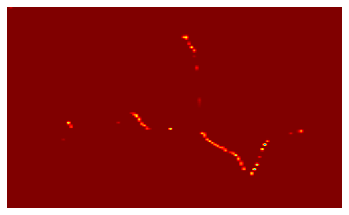

In [6]:
#feature map
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
 
# normalizing the output
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

image_path = '/data/tmpexec/ecg/test/9929-2.png' #V:Ventricular ectopic beat
oriImg = cv2.imread(image_path)
height, width, _ = oriImg.shape
#plt.axis('off')
#plt.imshow(oriImg)
data = []
oriImg = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))
data.append(oriImg)
data = torch.from_numpy(np.array(data)).type(torch.FloatTensor).cuda() 

activation = {}
best_net.net.register_forward_hook(get_activation('net'))#spatial attention
output = best_net(data.permute(0, 3, 1, 2))
feature = activation['net'].squeeze()
feature_0 = feature[0].cpu().numpy()
feature_0 = normalize_output(feature_0)
feature_0 = np.uint8(255 * feature_0)
#plot
#height, width, _ = oriImg.shape
featuremap = cv2.applyColorMap(cv2.resize(feature_0,(width, height)), cv2.COLORMAP_JET)
plt.axis('off')
plt.imshow(featuremap)